**тематическое моделирование**

_Евгений Борисов <esborisov@sevsu.ru>_

In [1]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## библиотеки

In [2]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

SKLEARN_VERSION

'1.0.2'

## тексты

In [4]:
data = pd.read_pickle('../data/news.pkl.gz')
print('текстов:',len(data))
data.sample(4)

текстов: 3196


,text,tag
242,"БЕЛЬГИЙЦЫ - САМЫЕ БОГАТЫЕ В ЗАПАДНОЙ ЕВРОПЕ Бельгийцы являются самыми\nбогатыми среди граждан стран Западной Европы, и по этому показателю они\nобогнали швейцарцев. Согласно данным, обнародованным...",politics
2313,"13.12.16 09:24\n\nМосква. 13 декабря. ИНТЕРФАКС - Следователи попросят суд арестовать сотрудницу полиции, которая, по данным СКР, находясь за рулем в состоянии опьянения, сбила насмерть двух пешех...",incident
2900,"Российская компания Marussia Motors существовала с 2008 по 2014 год и покинула этот мир с долгами и конфликтами. Хотя в стенах штаб-квартиры «Маруси» разрабатывалось несколько любопытных моделей, ...",auto
1388,"Митт Ромни расстался с мыслью стать госсекретарем США\n\nПо данным СМИ, Трамп объявит имя нового главы Госдепа во вторник утром, главным претендентом на пост является глава Exxon Mobil Рекс Тиллер...",politics


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
# def string_normalizer(s): 
#     return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

In [8]:
data.sample(3)

,text,tag,ctext
3157,28.07.2010. ИТАР-ТАСС - Программа ВОСТОК На Колыме успешно завершился\nэтнокультурный образовательныйэксперимент по программе поддержки северных\nнародов Губернские ведомости (Южно-Сахалинск) Севе...,social,итар-тасс - программа восток на колыме успешно завершился этнокультурный образовательныйэксперимент по программе поддержки северных народов губернские ведомости южно-сахалинск северные мотивы перв...
435,"Эммануэль, Мануэль или Марин: кто станет следующим президентом Франции?\n\n8 декабря 2016 в 8:07\n\nРусская служба Би-би-си\n\nЗа благорасположение французских избирателей на предстоящих 23 апреля...",politics,эммануэль мануэль или марин кто станет следующим президентом франции декабря в русская служба би-би-си за благорасположение французских избирателей на предстоящих апреля года президентских выборах...
21,"Контрактники могут получить льготы при поступлении в вузы... и внести в\nГосдуму проект федерального закона, направленного на обеспечение доступности\nвысшего образования для лиц, проходивших воен...",politics,контрактники могут получить льготы при поступлении в вузы и внести в госдуму проект федерального закона направленного на обеспечение доступности высшего образования для лиц проходивших военную слу...


## модели

In [9]:
def print_top_words(model, feature_names, n_top_words=7):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема %d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [10]:
n_features = 1000
n_components = 10

### CountVectorizer + LatentDirichletAllocation

In [15]:
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer(s,stopwords=stopwords): 
    for w in s.split(' '):
        if len(w)<2: continue
        if w in stopwords: continue
        yield w        
    return ''

In [16]:
%%time

# tf features 
tf_vectorizer = CountVectorizer( 
        max_df=.95, 
        min_df=2, 
        max_features=n_features,
        tokenizer=tokenizer, 
        token_pattern=None,
    )
tf = tf_vectorizer.fit_transform(data['ctext'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

# LDA - латентное размещение Дирихле
lda = LatentDirichletAllocation( 
        n_components=n_components, 
        max_iter=5,
        learning_method='online', 
        learning_offset=50.,
        random_state=0, 
    ).fit(tf)

print('\nLDA:\n')
print_top_words(lda, tf_feature_names)


LDA:

Тема 0: компания компании сети apple пользователей фото рынке
Тема 1: ученые коми путин ссср университета японии также
Тема 2: автомобиль дтп автомобилей результате км водитель автомобиля
Тема 3: мяч фильм лучший динамо матче получил очков
Тема 4: рублей народов млн коренных севера года малочисленных
Тема 5: это очень которые лет время года году
Тема 6: by tut декабря фото ноября внимание установлена
Тема 7: года декабря также россии мира году время
Тема 8: россии заявил беларуси декабря президента глава также
Тема 9: года сша декабря россии трамп ранее сообщает
CPU times: user 24.7 s, sys: 39.6 ms, total: 24.7 s
Wall time: 25.1 s


In [17]:
# LDA:

# Тема 0: на что по его года также как
# Тема 1: версия вас или не установлена браузер ваш
# Тема 2: object динамо украины sport на матча 14
# Тема 3: на до по декабря 00 рублей by
# Тема 4: на мяч чемпионата матче лучший команды сборной
# Тема 5: на что не будет для от при
# Тема 6: на года за из по году 2016
# Тема 7: народов коренных севера малочисленных края коми руб
# Тема 8: не на что но это как из
# Тема 9: по на из что за декабря не

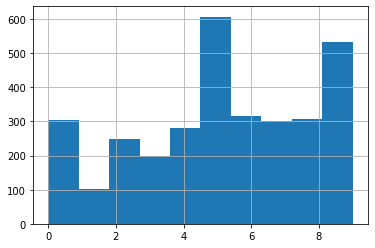

In [18]:
t = np.argmax(lda.transform(tf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (Frobenius norm)

In [27]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( 
    max_df=.95, 
    min_df=2, 
    max_features=n_features,
    tokenizer=tokenizer, 
    token_pattern=None,)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tf_vectorizer.get_feature_names_out()

# NMF (Frobenius norm) - неотрицательное матричное разложение
nmf = NMF( n_components=n_components, random_state=1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )

/opt/python3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



NMF:

Тема 0: это by tut беларуси очень декабря фото
Тема 1: трамп сша трампа дональд президент избранный президента
Тема 2: дтп водитель области результате мвд декабря происшествия
Тема 3: flash adobe javascript player проигрывателя html отключен
Тема 4: савченко украины партии надежда заявила лидер действия
Тема 5: народов севера коренных малочисленных края июля фестиваль
Тема 6: ученые университета специалисты могут часов исследования людей
Тема 7: рублей года компания млн компании году млрд
Тема 8: россии путин рф заявил россия глава алеппо
Тема 9: динамо матче чемпионата мира стал очков лучшим


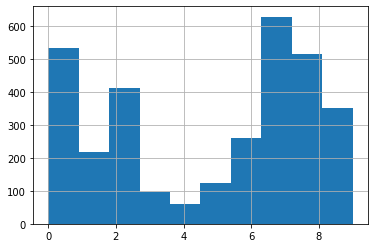

In [28]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (generalized Kullback-Leibler divergence)

In [29]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( 
    max_df=.95, 
    min_df=2, 
    max_features=n_features, 
    tokenizer=tokenizer, 
    token_pattern=None,)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tf_vectorizer.get_feature_names_out()

# NMF (generalized Kullback-Leibler divergence) 
nmf = NMF( n_components=n_components, random_state=1, beta_loss='kullback-leibler', 
          solver='mu', max_iter=1000,  l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )

/opt/python3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



NMF:

Тема 0: это фото декабря года который лет время
Тема 1: сша трамп президент трампа президента пост дональд
Тема 2: дтп области водитель результате мвд декабря сообщили
Тема 3: by tut декабря видео поддерживает установлена версия
Тема 4: савченко россии украины заявил путин декабря глава
Тема 5: народов млн рублей севера коренных области малочисленных
Тема 6: ученые специалисты университета людей жизни часов могут
Тема 7: компания компании рублей долларов года модели автомобиль
Тема 8: сообщает алеппо новости риа москва также сми
Тема 9: мира динамо стал матче чемпионата лучший место


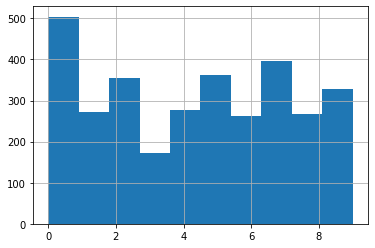

In [30]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()